## Albini Model in FDS6  
  
We decided that recreating the Albini and Reinhardt experiments in FDS6 would be a helpful process for many possible avenues of research. This may even be of use in the validation process for WFDS.    
  
### Description of the Geometry 
  
Our reading of the experiments dictated the geometry as follows:  
*  *The heat source was a grid of pipes roughly 1m to a side with 0.18cm holes roughly every 7.5 cm; about 7g/s of propane is pushed through the pipes to produce a flame roughly 1 cubic meter in size.* We created a 1m * 1m &VENT that produces a `HRRPUA=350` (kW/m^2) flame. This value was selected since it generated a reasonable approximation of the fire environment temperature.   
*  *Fuels were suspended roughly 70cm above the burner, immersed in the flame.* We initialized fuels in this same place.  
*  *A thermocouple embedded in Sauresian cement measured the temperature near the fuel element and showed an average temperature of 928°K.* We placed a &DEVC temperature sensor adjacent to the fuel element and recorded fluctuating temperature typically in the range of 600-800°C (870-1070°K).  
*  *Fuels consisted of limbs and boles of lodgepole pine between 2.5 and 10cm in diameter, sound and rotten, with and without bark, range of moisture contents.* We initialized &PARTicles with (cylindrical boundary conditions) between 2.5 and 10cm (0.5cm intervals) 1m long using the vegetation from William Mell's vege_mass_conservation_2 verification study (see below for material descriptions). For purposes of these experiments we disabled all pyrolysis (water and fuel) to compare the heat transfer.  
  
```
&MATL ID = 'VIRGIN VEGETATION'
      VEGETATION = .TRUE.
      DENSITY = 586.
      CONDUCTIVITY = 0.1
      SPECIFIC_HEAT= 2.0
      N_REACTIONS = 1
      A = 600000.
      E = 48221.
      N_T = -0.5
      NU_SPEC = 0.123
      SPEC_ID = 'WATER VAPOR'
      NU_MATL = 0.877
      MATL_ID = 'DRY VEGETATION'
      HEAT_OF_REACTION= 2259. /

&MATL ID = 'DRY VEGETATION'
      VEGETATION = .TRUE.
      DENSITY = 514.
      CONDUCTIVITY = 0.1
      SPECIFIC_HEAT= 2.0
      N_REACTIONS = 1
      A = 36300.
      E = 60277.
      NU_MATL = 0.26
      MATL_ID  = 'CHAR' 
      NU_SPEC = 0.74
      SPEC_ID = 'CELLULOSE'
      HEAT_OF_REACTION= 418. /

&MATL ID = 'CHAR'
      VEGETATION = .TRUE.
      DENSITY  = 134.
      CONDUCTIVITY = 0.1
      SPECIFIC_HEAT = 2.0
      N_REACTIONS = 1
      N_S = 0.
      NU_O2 = 1.65
      BETA_CHAR = 0.2
      A = 430.
      E = 74826.
      NU_MATL = 0.5
      MATL_ID  = 'ASH'
      NU_SPEC = 2.15
      SPEC_ID = 'CARBON DIOXIDE'
      HEAT_OF_REACTION= -32000. /

&MATL ID = 'ASH'
      VEGETATION = .TRUE.
      DENSITY = 67.
      CONDUCTIVITY = 0.1
      SPECIFIC_HEAT = 2.0 /
```  
  
### Results  
  
The simulation geometry described above seems to match our understanding of the experiments fairly well (see gif below). As such, we went on to measure parameters of interest from these simulations to see if they aligned with the results from the experiments.  
  
![A view of the simulation geometry](notebook_images/simulation.gif)  
  
  
#### Thermal thickness works as expected  
  
The earliest find of significance from this investigation is that thermally-thick &PARTicles in FDS6 appear to exhibit the properties we want. As can be seen below, a heat gradient forms in the &PARTicle as it is exposed to heat, but the resolution of the gradient is quite low. It's not clear at this time if solids can be forced to model this gradient at higher resolution though, as we will see in a later section, we can force FDS6 to model the gradient at a *lower* resolution by specifying `N_LAYER_CELLS_MAX`.  
  
![Heat gradient](notebook_images/1D_heat_line.gif)  
  

In the future, it will be helpful to directly compare this plot to another model (a finite element method approximation of the phenomenon) to assist in verification.

  
#### Time to Ignition  
  
We used the ignition temperature provided by the paper (327°C) and compared the results of fuels with thermally-thin (two unique implementations) and thermally-thick fuels. We found in both cases that thermally-thick fuels ignited much more rapidly and that diameter of the fuel element had little effect on the time of ignition.  
  
One immediate issue is that the experimenters did not label the fuel elements used in figures 2, 3 and 4 (plots of predicted versus observed time delays). This is a possible area where new burns could contribute valuable data to the literature.
  
##### Thermally-thick spheres versus thermally-thin droplet &PARTicles  
  
One approach to modeling thermally-thin fuels in W/FDS is to prescribe them as droplets of fuel. All droplets are considered to be thermally-thin and are generally quite small (though they may be large if needed). An example of this from a thermally-thin simulation:  
```
&PART ID='stick', SAMPLING_FACTOR=1, SPEC_ID='VIRGIN VEGETATION', PROP_ID='wood image', DIAMETER=25000, QUANTITIES='PARTICLE TEMPERATURE','PARTICLE MASS','PARTICLE DIAMETER', STATIC=.TRUE. /
```  
This creates a 2.5cm diameter spherical droplet of the prescribed SPECies.  
  
When we compare these thermally-thin fuels to thermally-thick spheres and identify the times at which ignition temperature is reached at the particle's surface, we can produce the following plot:  
  


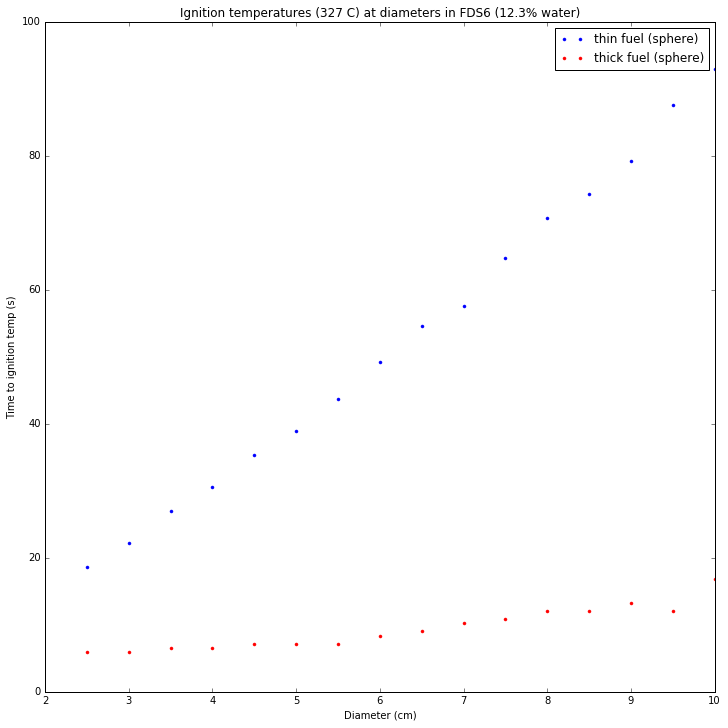

In [7]:
import os
import csv
import time
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

x_points = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# ignition times of thin sphere
y4_points = [1.8606547E+001,
             2.2209025E+001,
             2.7003514E+001,
             3.0611227E+001,
             3.5410736E+001,
             3.9011540E+001,
             4.3800676E+001,
             4.9209292E+001,
             5.4604590E+001,
             5.7605513E+001,
             6.4800807E+001,
             7.0800993E+001,
             7.4405928E+001,
             7.9203113E+001,
             8.7604069E+001,
             9.3011490E+001
            ]

# ignition times of thick spheres
y5_points = [6.0114046E+000,
             6.0125599E+000,
             6.6085962E+000,
             6.6082183E+000,
             7.2001586E+000,
             7.2035483E+000,
             7.2115554E+000,
             8.4051878E+000,
             9.0111831E+000,
             1.0209439E+001,
             1.0805481E+001,
             1.2009221E+001,
             1.2004253E+001,
             1.3206132E+001,
             1.2004253E+001,
             1.6802922E+001
            ]


ax.clear()
ax.plot(x_points, y4_points, color="blue", marker='.', linestyle="None", label="thin fuel (sphere)")
ax.plot(x_points, y5_points, color="red", marker='.', linestyle="None", label="thick fuel (sphere)")
ax.set_title("Ignition temperatures (327 C) at diameters in FDS6 (12.3% water)")
ax.set_xlabel("Diameter (cm)")
ax.set_ylabel("Time to ignition temp (s)")
ax.set_ylim([0, 100])
ax.legend()
fig.canvas.draw()
plt.show(block=True)

Please note that the inherent uncertainty in material properties (those above) will affect these results.  
  
##### Thermally-thick spheres versus thermally-thin solid &PARTicles   
  
Another approach we found more recently is to decrease the maximum resolution of the thermally-thick particle until it is treated as a single layer; this is probably the better method since it conserves more of the physical properties of the fuel and allows for different geometries (including cylinders). It is also simpler to impose this condition once you know what you're looking for-- it goes on the &SURFace line associated with the &PARTicle you are trying to burn. For example:  
  
```
- a 2.5cm thick, 1m long stick
&SURF ID='stick_surf', MATL_ID='VIRGIN VEGETATION', RADIUS=0.0125, GEOMETRY='SPHERICAL', N_LAYER_CELLS_MAX=1 /
```  
  
The `N_LAYER_CELLS_MAX` argument specifies that the fuel should be treated as a single cell-- thus it is thermally-thin.  
  
This is relatively new to us but preliminary examination of ignition times (like those done above) leads to interesting results as well:

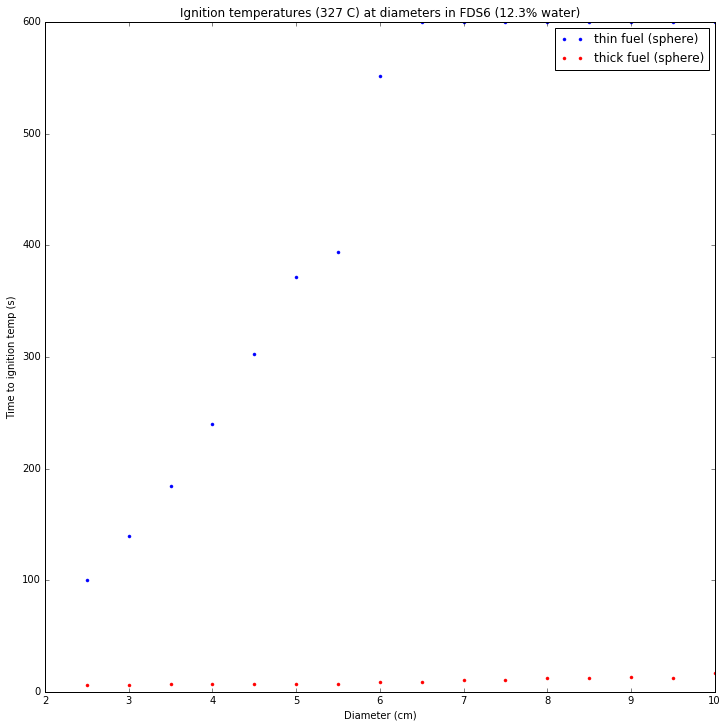

In [5]:
import os
import csv
import time
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

x_points = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# ignition times of thick spheres
y5_points = [6.0114046E+000,
             6.0125599E+000,
             6.6085962E+000,
             6.6082183E+000,
             7.2001586E+000,
             7.2035483E+000,
             7.2115554E+000,
             8.4051878E+000,
             9.0111831E+000,
             1.0209439E+001,
             1.0805481E+001,
             1.2009221E+001,
             1.2004253E+001,
             1.3206132E+001,
             1.2004253E+001,
             1.6802922E+001
            ]

# ignition times of thin (single cell) spheres
y5b_points = [1.0020916E+002,
             1.3920862E+002,
             1.8480545E+002,
             2.4001173E+002,
             3.0240997E+002,
             3.7200568E+002,
             3.9420216E+002,
             5.5200652E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
             6.0000000E+002,
            ]

ax.clear()
ax.plot(x_points, y5b_points, color="blue", marker='.', linestyle="None", label="thin fuel (sphere)")
ax.plot(x_points, y5_points, color="red", marker='.', linestyle="None", label="thick fuel (sphere)")
ax.set_title("Ignition temperatures (327 C) at diameters in FDS6 (12.3% water)")
ax.set_xlabel("Diameter (cm)")
ax.set_ylabel("Time to ignition temp (s)")
ax.set_ylim([0, 600])
ax.legend()
fig.canvas.draw()
plt.show(block=True)

As can be seen, the differences in time to reach ignition temperature are even more drastic when modeled using solid &PARTicles. Please note that the inherent uncertainty in material properties (those above) will affect these results.  
  
It is also important to remember that the time for the surface of the fuel to reach ignition temperature doesn't necessarily equate to the observed time delay to ignition; it is a helpful measurement (one, in fact, that may have been beyond the experimenters' means to measure at the time) but not the same as the visual identification of ignition that they used.
  
#### Fractional weight loss  
  
The other area of study that Albini and Reinhardt put forward was the fractional weight loss of a large woody fuel with respect to time. The last three figures in their paper (5, 6 and 7) show the weight loss of fuels compared to model estimations over time. We compared the fractional weight loss of fuels matching these dimensions to the data line in their plots (values determined by straight edge) to recreate these plots. (**Note: the script will not generate a plot because the data files are not present**)

In [ ]:
import os
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

def fractional_loss(current, initial):
    return((initial - current)/initial)

def albini_fig_5_fn():
    xs = [0,60,120,180,240]
    ys = [0,0.07,0.13,0.20,0.265]
    points = [xs, ys]
    return(points)

pointfile = os.getcwd() + "/" + "albini_batch_runs_6/albini_48mm_pyro/albini_model_devc.csv"
alb_data = albini_fig_5_fn()
ylims = [0,0.4]
xlims = [0,300]
xtics = [0,60,120,180,240,300]

values = []

with open(pointfile, 'r') as f:
    # skip first line (units -> s, C, C, C, ... C)
    f.next()
    reader = csv.DictReader(f)
    for row in reader:
        values.append(row)
    times = []
    masses = []
    initial_mass = 0.0 #will write over this in loop
    for timestep in values:
        if len(times) == 0: #first time iteration
            initial_mass = float(timestep["mass"])
        t = float(timestep["Time"])
        times.append(t)
        mass = fractional_loss(float(timestep["mass"]) , initial_mass)
        masses.append(mass)

    delay = 0.00
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(111)
    ax.clear()
    ax.plot(times, masses, color='black', marker='.', label='Simulation')
    xnew = np.linspace(alb_data[0][0], alb_data[0][-1], 10)
    yfn = scipy.interpolate.interp1d(alb_data[0], alb_data[1], kind='slinear')
    ynew = yfn(xnew)
    ax.plot(alb_data[0], alb_data[1], color='red', marker='.', linestyle="None" )
    ax.plot(xnew, ynew, color='red', label='Albini data')
    ax.set_title("Fractional weight loss of fuel element")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fractional weight loss")
    ax.set_ylim(ylims)
    ax.set_xticks(xtics)
    ax.legend()
    fig.show()

![Figure 5](notebook_images/albini_mass_pltfig_5new.png)
Figure 5  
![Figure 6](notebook_images/albini_mass_pltfig_6new.png)
Figure 6  
![Figure 7](notebook_images/albini_mass_pltfig_7new.png)  
Figure 7
  
The mass loss is obviously much smaller than that of the experiments. One likely explanation is that the materials we are burning are not properly described; as mentioned above, these were lifted directly from the FDS6 file `fds/Verification/Vegetation/vege_mass_conservation_2.fds` and are intended to represent bulk needles, not necessarily wood. This is a problem that could be resolved either by recorded data or new burns.

## Douglas Fir Model in FDS6: Thin versus Thick treatment of &PARTicles  
  
### The NIST Douglas Fir Validation Models  
  
There are validation studies in FDS6 that examine a burning Douglas Fir. As written, the model uses thermally-thick &PARTicles of several sizes randomly distributed inside of a cone. We decided it would be interesting to compare the temperatures and carbon product release of this model to an identical model with thermally-thin fuels (using the `N_LAYER_CELLS_MAX=1` flag above).  
  
Our first run, with only the described change, shows significant differences in fire behavior (see side by side comparison gif below). These results occurred with a fire temperature of 1300.  
  
```
&PART ID='ignitor', SAMPLING_FACTOR=1, SURF_ID='burner', STATIC=.TRUE. /
&SURF ID='burner', TMP_FRONT=3000., TAU_T=0.05, RADIUS=0.01, GEOMETRY='SPHERICAL' /
&INIT PART_ID='ignitor', XYZ=0.0,0.0,0.21, RADIUS=0.40, SHAPE='RING', N_PARTICLES=400  /
```
  (plot goes here)
![High temperature](notebook_images/NIST_gas_release_normal.png)  
  
  
![Tree burns](notebook_images/thin_vs_thick.gif)
Left = thick; right = thin
**NOTE: the temperature scales on these images are very different! (0-770 vs 0-420)**
  
  
We decided to try the burn again with substantially increased temperature and duration. We found that with substantial temperature increase (description below, note `TMP_FRONT`) thin fuels begin to very closely approximate the gas release characteristics of thick fuels and the smokeview results look very similar as well.  
  
```
&PART ID='ignitor', SAMPLING_FACTOR=1, SURF_ID='burner', STATIC=.TRUE. /
&SURF ID='burner', TMP_FRONT=3000., TAU_T=0.05, RADIUS=0.01, GEOMETRY='SPHERICAL' /
&INIT PART_ID='ignitor', XYZ=0.0,0.0,0.21, RADIUS=0.40, SHAPE='RING', N_PARTICLES=400  /
```  

![High temperature](notebook_images/NIST_gas_release_hot.png)  
  
~